In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.signal import savgol_filter
from lmfit import Minimizer, Parameters, create_params, report_fit, Model
import sys
sys.path.append('../src')
import json

In [2]:
list_seq = ['SEQ1', 'SEQ2', 'SEQ3']
with open('results_dict.txt', 'r') as file:
    results_dict = json.load(file)
    
results_dict_cvsans = {}

In [3]:
N_A = 6e23 # mol^-1
# unit of b: angstrom
bO = 5.803e-5 
bC = 6.6460e-5
bS = 2.847e-5
bN = 9.36e-5
bD = 6.671e-5
bH = -3.7390e-5
bpol = 161 * bC + 300 * bH + 27 * bN + 45 * bO
bD2O = 2 * bD + 2 * bO
bH2O = 2 * bH + 1 * bO

Mpol = 161 * 12.01 + 300 * 1 + 27 * 14.01 + 45 * 16.00 # g*mol^-1

dpol = 1.08 # g/cm^3
npol = 1.08 / Mpol * N_A # number density, cm^-3
nH2O = 1.0 / 18.02 * N_A # number density, cm^-3

rho_pol = bpol * npol *1e-8 # scattering length density, cm^-2
rho_H2O = bH2O * nH2O *1e-8 # scattering length density, cm^-2
rho_D2O = bD2O * nH2O *1e-8 # scattering length density, cm^-2

Vs = (1-(0.3/100))/1.0
Vpol = 0.3/100/dpol
V_all = Vs + Vpol
Vs = Vs/V_all # volume fraction of solvent
Vpol = Vpol/V_all # volume fraction of polymer

print('Vpol = ', Vpol)
print('Vs = ', Vs)

Vpol =  0.002778395198933096
Vs =  0.9972216048010669


In [4]:
import matplotlib.colors as mcolors
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
# Convert color codes to RGB
colors_rgb = [mcolors.to_rgb(color) for color in colors]

C_fit = 111.94231755151606
R_g = 49.6843 +/- 16.5478
R_g = 49.6843 +/- 16.5478
R_g = 49.6843 +/- 16.5478


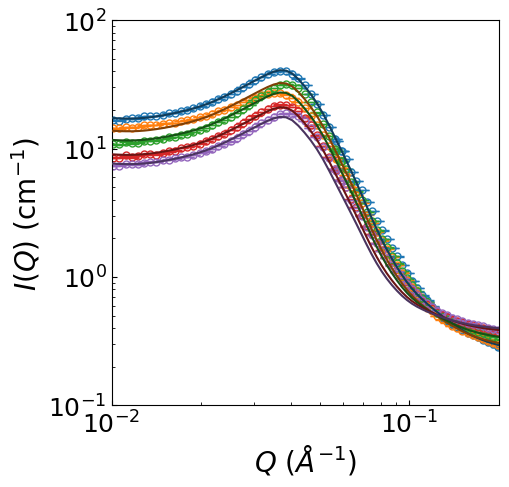

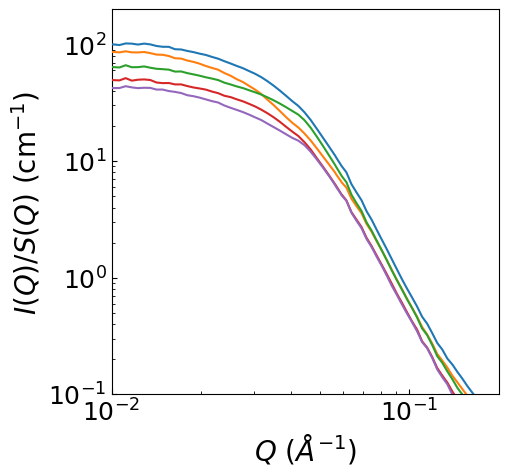

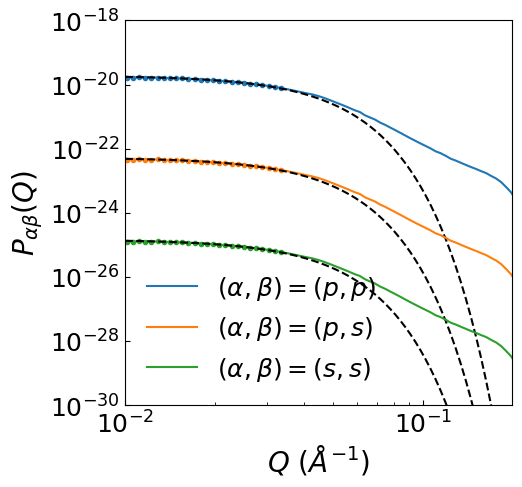

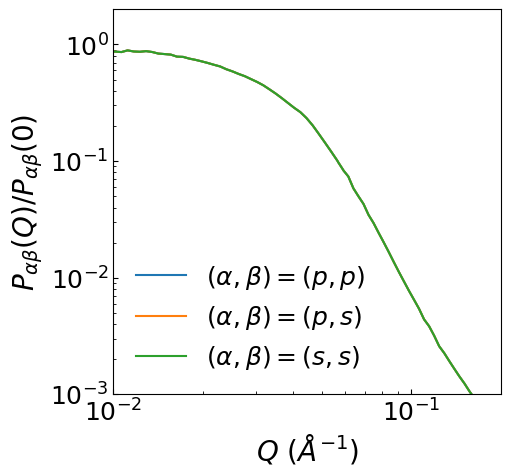

In [5]:
i_seq = 0
seq = list_seq[i_seq]
# load fitted results from 100% D2O
params_fit = {key: float(str(value).split('value=')[1].split(' +/-')[0]) for key, value in results_dict[seq]['params_fit'].items()}
S_fit = np.array(results_dict[seq]['S_fit'])
P_fit = np.array(results_dict[seq]['P_fit'])
C_fit = params_fit['C']
I_inc_fit = params_fit['I_inc']
print('C_fit = {}'.format(C_fit))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

fig2 = plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111)

list_gamma = [1.0, 0.95, 0.9, 0.85, 0.8]

list_rho_p = [] # excess scattering length density of polymers
list_rho_s = [] # excess scattering length density of solvent
list_I_inc = [] # incoherent background
array_I = []
array_rho = []
for i_gamma, gamma in enumerate(list_gamma):
    
    # load data
    filename = f'../data/semidilute-anionic/{seq}-anionic-semi/EHT-CVSANS-{seq}-anionic-semi-{int(gamma*100):03d}.dat'
    data = np.loadtxt(filename, skiprows=2)
    q_data = data[:, 0]
    I_data = data[:, 1]
    I_data_err = data[:, 2]
    q_data_err = data[:, 3]
    
    list_rho_p.append(rho_pol)
    rho_s = rho_D2O*gamma + rho_H2O*(1-gamma)
    list_rho_s.append(rho_s)
    
    rho_bg = (Vs*rho_s + Vpol*rho_pol)/(Vs+Vpol)
    
    row_rho = [(rho_pol-rho_bg)**2, (rho_pol-rho_bg)*(rho_s-rho_bg), (rho_s-rho_bg)**2]
    array_rho.append(row_rho)
    
    # fit the lower q region using fixed S to extract the incoherent background
    # assuming P(q) didn't change a lot in this region
    C0 = C_fit*gamma
    I_inc0 = I_inc_fit
    params = Parameters()
    params.add('C', value=C0, min=C0/5, max=C0*5)
    params.add('I_inc', value=I_inc0, min=I_inc0/5, max=I_inc0*5)
    
    q_min = 0.04
    q_max = 0.15
    index_Q = np.where((((q_data<q_min) | (q_data>q_max)) & (q_data<0.2)) & (q_data>0.01))[0]
    def IQ_th(params):
        v = params.valuesdict()
        I = v['C']*S_fit*P_fit/C_fit + v['I_inc']
        return I
    
    def lmbda(params, Q, IQ_exp, index_Q):
        IQ = IQ_th(params)
        # minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
        minimizer_target = lambda x, y: np.log(y/x)
        return minimizer_target(IQ[index_Q],IQ_exp[index_Q])

    # do fit, here with the nelder algorithm
    minner = Minimizer(lmbda, params, fcn_args=(q_data, I_data, index_Q))
    result = minner.minimize('powell')
    
    # report_fit(result)
    v_result = result.params.valuesdict()
    
    # print('gamma = {}'.format(gamma))
    # print('C = {}'.format(v_result['C']))
    # print('I_inc = {}'.format(v_result['I_inc']))
    
    list_I_inc.append(v_result['I_inc'])
    
    ax.errorbar(q_data, I_data, yerr=I_data_err, fmt='o', markersize=5, label=r'$I_\mathrm{exp}(Q)$', fillstyle='none', capsize=5, color = colors[i_gamma])
    ax.plot(q_data, IQ_th(result.params), '-', zorder=10, color = np.array(colors_rgb[i_gamma])/2)
    
    ax2.plot(q_data, (I_data-v_result['I_inc'])/S_fit, '-', zorder=10, color = colors[i_gamma])
    
    array_I.append((I_data-v_result['I_inc'])/S_fit)
    
array_I = np.array(array_I)
array_rho = np.array(array_rho)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01, 0.2])
ax.set_ylim([1e-1, 1e2])  

ax.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax.set_ylabel(r'$I(Q)\ (\mathrm{cm}^{-1})$', fontsize=20)

# ax.set_yscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([0.01, 0.2])
ax2.set_ylim([1e-1, 2e2])  

ax2.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax2.set_ylabel(r'$I(Q)/S(Q)\ (\mathrm{cm}^{-1})$', fontsize=20)

# ax.set_yscale('log')
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
## apply cvsans and extract the partial scattering length density
# array_I = array_rho@array_S, find array_S, unit: cm^-1 = cm-2 * cm
array_S = np.linalg.lstsq(array_rho, array_I, rcond=None)[0] # unit: cm

sgn = np.sign(array_S[:,0])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

fig2 = plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111)

label_list = [r'$(\alpha,\beta) = (p,p)$', r'$(\alpha,\beta) = (p,s)$', r'$(\alpha,\beta) = (s,s)$']
list_I_0 = []
list_R_g = []
list_dR_g = []
for components in np.arange(3):
    # Guinier fit
    I_s = array_S[components,:]*sgn[components]
    
    q_min = 0.005
    q_max = 0.034
    index_Q = np.where(((q_data>q_min) & (q_data<q_max)))[0]
    
    q_data_gu = q_data[index_Q]
    lnI_data_gu = np.log(I_s[index_Q])
    
    # I_fit_gu = array_q@coeff
    array_q = np.array([np.ones_like(q_data_gu), q_data_gu**2]).T
    coeff, residuals, rank, s = np.linalg.lstsq(array_q, lnI_data_gu, rcond=None)
    # print('coeff = {}'.format(coeff))
    
    array_q_data = np.array([np.ones_like(q_data), q_data**2]).T
    lnI_fit_gu = (array_q_data @ coeff).flatten()
    
    ax.plot(q_data, I_s, label=label_list[components], color=colors[components])
    ax.plot(q_data_gu, np.exp(lnI_data_gu), '.', color=colors[components])
    ax.plot(q_data, np.exp(lnI_fit_gu), 'k--')
    
    I_0 = np.exp(coeff[0])
    R_g = np.sqrt(-coeff[1] * 3)
    
    # Calculate the uncertainty of R_g
    cov_matrix = np.linalg.inv(array_q.T @ array_q)
    uncertainty_R_g = 0.5 * np.sqrt(3) * np.sqrt(cov_matrix[1, 1]) / np.sqrt(-coeff[1])
    print('R_g = {:0.4f} +/- {:0.4f}'.format(R_g, uncertainty_R_g))
    
    list_I_0.append(I_0)
    list_R_g.append(R_g)
    list_dR_g.append(uncertainty_R_g)
    
    ax2.plot(q_data, I_s/I_0, label=label_list[components], color=colors[components])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-30, 1e-18])
ax.set_xlim([0.01, 0.2])

ax.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax.set_ylabel(r'$P_{\alpha\beta}(Q)$', fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax.legend(fontsize=18, loc='best', frameon=False)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim([1e-3, 2e0])
ax2.set_xlim([0.01, 0.2])

ax2.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax2.set_ylabel(r'$P_{\alpha\beta}(Q)/P_{\alpha\beta}(0)$', fontsize=20)
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax2.legend(fontsize=18, loc='best', frameon=False)

results_dict_cvsans[seq] = {
    'Q_fit': q_data.tolist(),
    'P_alpha_beta': array_S.tolist(),
    'list_I_0': list_I_0,
    'list_R_g': list_R_g,
    'list_dR_g': list_dR_g
}

C_fit = 72.44157406506031
R_g = 44.5935 +/- 10.8398
R_g = 44.5935 +/- 10.8398
R_g = 44.5935 +/- 10.8398


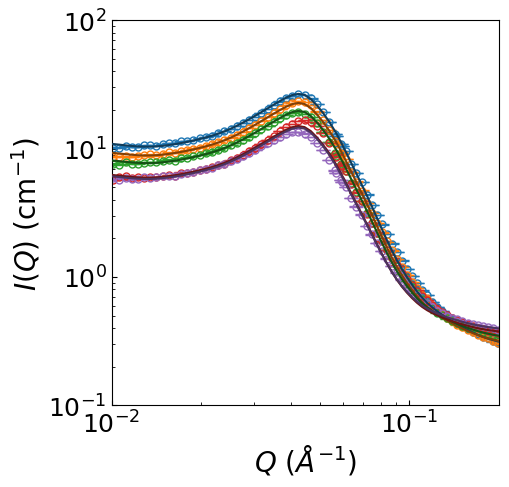

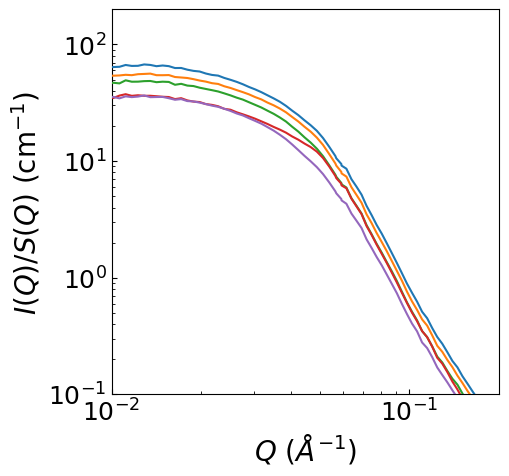

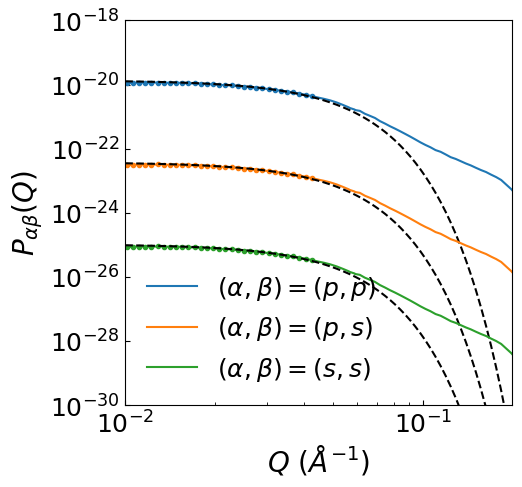

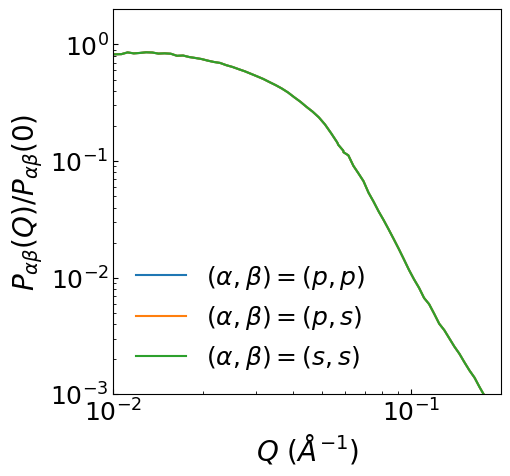

In [6]:
i_seq = 1
seq = list_seq[i_seq]
# load fitted results from 100% D2O
params_fit = {key: float(str(value).split('value=')[1].split(' +/-')[0]) for key, value in results_dict[seq]['params_fit'].items()}
S_fit = np.array(results_dict[seq]['S_fit'])
P_fit = np.array(results_dict[seq]['P_fit'])
C_fit = params_fit['C']
I_inc_fit = params_fit['I_inc']
print('C_fit = {}'.format(C_fit))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

fig2 = plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111)

list_gamma = [1.0, 0.95, 0.9, 0.85, 0.8]

list_rho_p = [] # excess scattering length density of polymers
list_rho_s = [] # excess scattering length density of solvent
list_I_inc = [] # incoherent background
array_I = []
array_rho = []
for i_gamma, gamma in enumerate(list_gamma):
    
    # load data
    filename = f'../data/semidilute-anionic/{seq}-anionic-semi/EHT-CVSANS-{seq}-anionic-semi-{int(gamma*100):03d}.dat'
    data = np.loadtxt(filename, skiprows=2)
    q_data = data[:, 0]
    I_data = data[:, 1]
    I_data_err = data[:, 2]
    q_data_err = data[:, 3]
    
    list_rho_p.append(rho_pol)
    rho_s = rho_D2O*gamma + rho_H2O*(1-gamma)
    list_rho_s.append(rho_s)
    
    rho_bg = (Vs*rho_s + Vpol*rho_pol)/(Vs+Vpol)
    
    row_rho = [(rho_pol-rho_bg)**2, (rho_pol-rho_bg)*(rho_s-rho_bg), (rho_s-rho_bg)**2]
    array_rho.append(row_rho)
    
    # fit the lower q region using fixed S to extract the incoherent background
    # assuming P(q) didn't change a lot in this region
    C0 = C_fit*gamma
    I_inc0 = I_inc_fit
    params = Parameters()
    params.add('C', value=C0, min=C0/5, max=C0*5)
    params.add('I_inc', value=I_inc0, min=I_inc0/5, max=I_inc0*5)
    
    q_min = 0.04
    q_max = 0.15
    index_Q = np.where((((q_data<q_min) | (q_data>q_max)) & (q_data<0.2)) & (q_data>0.01))[0]
    def IQ_th(params):
        v = params.valuesdict()
        I = v['C']*S_fit*P_fit/C_fit + v['I_inc']
        return I
    
    def lmbda(params, Q, IQ_exp, index_Q):
        IQ = IQ_th(params)
        # minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
        minimizer_target = lambda x, y: np.log(y/x)
        return minimizer_target(IQ[index_Q],IQ_exp[index_Q])

    # do fit, here with the nelder algorithm
    minner = Minimizer(lmbda, params, fcn_args=(q_data, I_data, index_Q))
    result = minner.minimize('powell')
    
    # report_fit(result)
    v_result = result.params.valuesdict()
    
    # print('gamma = {}'.format(gamma))
    # print('C = {}'.format(v_result['C']))
    # print('I_inc = {}'.format(v_result['I_inc']))
    
    list_I_inc.append(v_result['I_inc'])
    
    ax.errorbar(q_data, I_data, yerr=I_data_err, fmt='o', markersize=5, label=r'$I_\mathrm{exp}(Q)$', fillstyle='none', capsize=5, color = colors[i_gamma])
    ax.plot(q_data, IQ_th(result.params), '-', zorder=10, color = np.array(colors_rgb[i_gamma])/2)
    
    ax2.plot(q_data, (I_data-v_result['I_inc'])/S_fit, '-', zorder=10, color = colors[i_gamma])
    
    array_I.append((I_data-v_result['I_inc'])/S_fit)
    
array_I = np.array(array_I)
array_rho = np.array(array_rho)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01, 0.2])
ax.set_ylim([1e-1, 1e2])  

ax.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax.set_ylabel(r'$I(Q)\ (\mathrm{cm}^{-1})$', fontsize=20)

# ax.set_yscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([0.01, 0.2])
ax2.set_ylim([1e-1, 2e2])  

ax2.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax2.set_ylabel(r'$I(Q)/S(Q)\ (\mathrm{cm}^{-1})$', fontsize=20)

# ax.set_yscale('log')
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
## apply cvsans and extract the partial scattering length density
# array_I = array_rho@array_S, find array_S, unit: cm^-1 = cm-2 * cm
array_S = np.linalg.lstsq(array_rho, array_I, rcond=None)[0] # unit: cm

sgn = np.sign(array_S[:,0])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

fig2 = plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111)

label_list = [r'$(\alpha,\beta) = (p,p)$', r'$(\alpha,\beta) = (p,s)$', r'$(\alpha,\beta) = (s,s)$']
list_I_0 = []
list_R_g = []
list_dR_g = []
for components in np.arange(3):
    # Guinier fit
    I_s = array_S[components,:]*sgn[components]
    
    q_min = 0.005
    q_max = 0.044
    index_Q = np.where(((q_data>q_min) & (q_data<q_max)))[0]
    
    q_data_gu = q_data[index_Q]
    lnI_data_gu = np.log(I_s[index_Q])
    
    # I_fit_gu = array_q@coeff
    array_q = np.array([np.ones_like(q_data_gu), q_data_gu**2]).T
    coeff, residuals, rank, s = np.linalg.lstsq(array_q, lnI_data_gu, rcond=None)
    # print('coeff = {}'.format(coeff))
    
    array_q_data = np.array([np.ones_like(q_data), q_data**2]).T
    lnI_fit_gu = (array_q_data @ coeff).flatten()
    
    ax.plot(q_data, I_s, label=label_list[components], color=colors[components])
    ax.plot(q_data_gu, np.exp(lnI_data_gu), '.', color=colors[components])
    ax.plot(q_data, np.exp(lnI_fit_gu), 'k--')
    
    I_0 = np.exp(coeff[0])
    R_g = np.sqrt(-coeff[1] * 3)
    
    # Calculate the uncertainty of R_g
    cov_matrix = np.linalg.inv(array_q.T @ array_q)
    uncertainty_R_g = 0.5 * np.sqrt(3) * np.sqrt(cov_matrix[1, 1]) / np.sqrt(-coeff[1])
    print('R_g = {:0.4f} +/- {:0.4f}'.format(R_g, uncertainty_R_g))
    
    list_I_0.append(I_0)
    list_R_g.append(R_g)
    list_dR_g.append(uncertainty_R_g)
    
    ax2.plot(q_data, I_s/I_0, label=label_list[components], color=colors[components])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-30, 1e-18])
ax.set_xlim([0.01, 0.2])

ax.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax.set_ylabel(r'$P_{\alpha\beta}(Q)$', fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax.legend(fontsize=18, loc='best', frameon=False)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim([1e-3, 2e0])
ax2.set_xlim([0.01, 0.2])

ax2.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax2.set_ylabel(r'$P_{\alpha\beta}(Q)/P_{\alpha\beta}(0)$', fontsize=20)
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax2.legend(fontsize=18, loc='best', frameon=False)

results_dict_cvsans[seq] = {
    'Q_fit': q_data.tolist(),
    'P_alpha_beta': array_S.tolist(),
    'list_I_0': list_I_0,
    'list_R_g': list_R_g,
    'list_dR_g': list_dR_g
}

C_fit = 49.663967338215045
R_g = 39.0603 +/- 7.3661
R_g = 39.0603 +/- 7.3661
R_g = 39.0603 +/- 7.3661


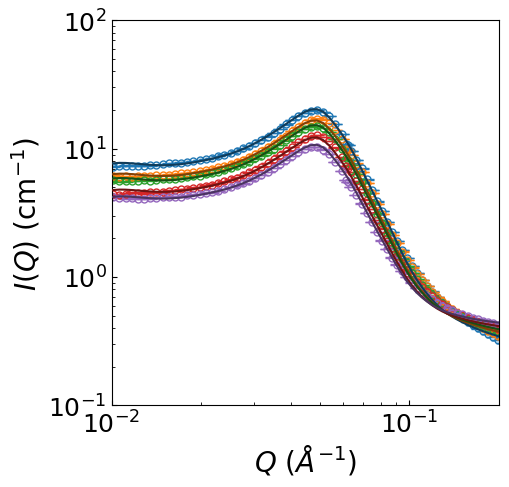

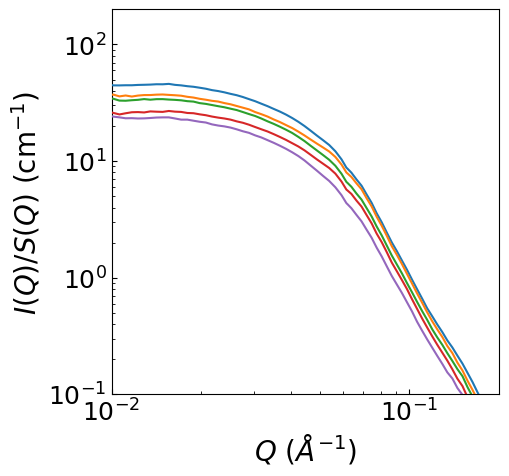

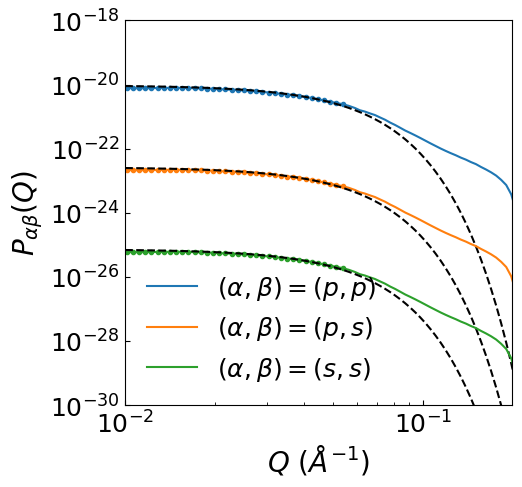

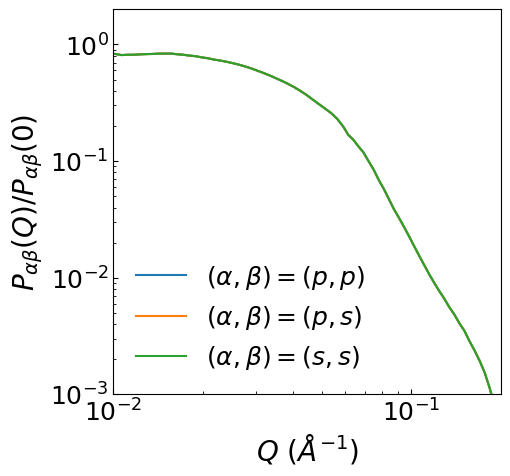

In [7]:
i_seq = 2
seq = list_seq[i_seq]
# load fitted results from 100% D2O
params_fit = {key: float(str(value).split('value=')[1].split(' +/-')[0]) for key, value in results_dict[seq]['params_fit'].items()}
S_fit = np.array(results_dict[seq]['S_fit'])
P_fit = np.array(results_dict[seq]['P_fit'])
C_fit = params_fit['C']
I_inc_fit = params_fit['I_inc']
print('C_fit = {}'.format(C_fit))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

fig2 = plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111)

list_gamma = [1.0, 0.95, 0.9, 0.85, 0.8]

list_rho_p = [] # excess scattering length density of polymers
list_rho_s = [] # excess scattering length density of solvent
list_I_inc = [] # incoherent background
array_I = []
array_rho = []
for i_gamma, gamma in enumerate(list_gamma):
    
    # load data
    filename = f'../data/semidilute-anionic/{seq}-anionic-semi/EHT-CVSANS-{seq}-anionic-semi-{int(gamma*100):03d}.dat'
    data = np.loadtxt(filename, skiprows=2)
    q_data = data[:, 0]
    I_data = data[:, 1]
    I_data_err = data[:, 2]
    q_data_err = data[:, 3]
    
    list_rho_p.append(rho_pol)
    rho_s = rho_D2O*gamma + rho_H2O*(1-gamma)
    list_rho_s.append(rho_s)
    
    rho_bg = (Vs*rho_s + Vpol*rho_pol)/(Vs+Vpol)
    
    row_rho = [(rho_pol-rho_bg)**2, (rho_pol-rho_bg)*(rho_s-rho_bg), (rho_s-rho_bg)**2]
    array_rho.append(row_rho)
    
    # fit the lower q region using fixed S to extract the incoherent background
    # assuming P(q) didn't change a lot in this region
    C0 = C_fit*gamma
    I_inc0 = I_inc_fit
    params = Parameters()
    params.add('C', value=C0, min=C0/5, max=C0*5)
    params.add('I_inc', value=I_inc0, min=I_inc0/5, max=I_inc0*5)
    
    q_min = 0.04
    q_max = 0.15
    index_Q = np.where((((q_data<q_min) | (q_data>q_max)) & (q_data<0.2)) & (q_data>0.01))[0]
    def IQ_th(params):
        v = params.valuesdict()
        I = v['C']*S_fit*P_fit/C_fit + v['I_inc']
        return I
    
    def lmbda(params, Q, IQ_exp, index_Q):
        IQ = IQ_th(params)
        # minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
        minimizer_target = lambda x, y: np.log(y/x)
        return minimizer_target(IQ[index_Q],IQ_exp[index_Q])

    # do fit, here with the nelder algorithm
    minner = Minimizer(lmbda, params, fcn_args=(q_data, I_data, index_Q))
    result = minner.minimize('powell')
    
    # report_fit(result)
    v_result = result.params.valuesdict()
    
    # print('gamma = {}'.format(gamma))
    # print('C = {}'.format(v_result['C']))
    # print('I_inc = {}'.format(v_result['I_inc']))
    
    list_I_inc.append(v_result['I_inc'])
    
    ax.errorbar(q_data, I_data, yerr=I_data_err, fmt='o', markersize=5, label=r'$I_\mathrm{exp}(Q)$', fillstyle='none', capsize=5, color = colors[i_gamma])
    ax.plot(q_data, IQ_th(result.params), '-', zorder=10, color = np.array(colors_rgb[i_gamma])/2)
    
    ax2.plot(q_data, (I_data-v_result['I_inc'])/S_fit, '-', zorder=10, color = colors[i_gamma])
    
    array_I.append((I_data-v_result['I_inc'])/S_fit)
    
array_I = np.array(array_I)
array_rho = np.array(array_rho)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01, 0.2])
ax.set_ylim([1e-1, 1e2])  

ax.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax.set_ylabel(r'$I(Q)\ (\mathrm{cm}^{-1})$', fontsize=20)

# ax.set_yscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([0.01, 0.2])
ax2.set_ylim([1e-1, 2e2])  

ax2.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax2.set_ylabel(r'$I(Q)/S(Q)\ (\mathrm{cm}^{-1})$', fontsize=20)

# ax.set_yscale('log')
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
## apply cvsans and extract the partial scattering length density
# array_I = array_rho@array_S, find array_S, unit: cm^-1 = cm-2 * cm
array_S = np.linalg.lstsq(array_rho, array_I, rcond=None)[0] # unit: cm

sgn = np.sign(array_S[:,0])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

fig2 = plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111)

label_list = [r'$(\alpha,\beta) = (p,p)$', r'$(\alpha,\beta) = (p,s)$', r'$(\alpha,\beta) = (s,s)$']
list_I_0 = []
list_R_g = []
list_dR_g = []
for components in np.arange(3):
    # Guinier fit
    I_s = array_S[components,:]*sgn[components]
    
    q_min = 0.005
    q_max = 0.055
    index_Q = np.where(((q_data>q_min) & (q_data<q_max)))[0]
    
    q_data_gu = q_data[index_Q]
    lnI_data_gu = np.log(I_s[index_Q])
    
    # I_fit_gu = array_q@coeff
    array_q = np.array([np.ones_like(q_data_gu), q_data_gu**2]).T
    coeff, residuals, rank, s = np.linalg.lstsq(array_q, lnI_data_gu, rcond=None)
    # print('coeff = {}'.format(coeff))
    
    array_q_data = np.array([np.ones_like(q_data), q_data**2]).T
    lnI_fit_gu = (array_q_data @ coeff).flatten()
    
    ax.plot(q_data, I_s, label=label_list[components], color=colors[components])
    ax.plot(q_data_gu, np.exp(lnI_data_gu), '.', color=colors[components])
    ax.plot(q_data, np.exp(lnI_fit_gu), 'k--')
    
    I_0 = np.exp(coeff[0])
    R_g = np.sqrt(-coeff[1] * 3)
    
    # Calculate the uncertainty of R_g
    cov_matrix = np.linalg.inv(array_q.T @ array_q)
    uncertainty_R_g = 0.5 * np.sqrt(3) * np.sqrt(cov_matrix[1, 1]) / np.sqrt(-coeff[1])
    print('R_g = {:0.4f} +/- {:0.4f}'.format(R_g, uncertainty_R_g))
    
    list_I_0.append(I_0)
    list_R_g.append(R_g)
    list_dR_g.append(uncertainty_R_g)
    
    ax2.plot(q_data, I_s/I_0, label=label_list[components], color=colors[components])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-30, 1e-18])
ax.set_xlim([0.01, 0.2])

ax.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax.set_ylabel(r'$P_{\alpha\beta}(Q)$', fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax.legend(fontsize=18, loc='best', frameon=False)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim([1e-3, 2e0])
ax2.set_xlim([0.01, 0.2])

ax2.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax2.set_ylabel(r'$P_{\alpha\beta}(Q)/P_{\alpha\beta}(0)$', fontsize=20)
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax2.legend(fontsize=18, loc='best', frameon=False)

results_dict_cvsans[seq] = {
    'Q_fit': q_data.tolist(),
    'P_alpha_beta': array_S.tolist(),
    'list_I_0': list_I_0,
    'list_R_g': list_R_g,
    'list_dR_g': list_dR_g
}

In [8]:
# Convert results_dict to a JSON string
results_json = json.dumps(results_dict_cvsans, indent=4, default=str)

# Write the JSON string to a text file
with open('results_dict_cvsans.txt', 'w') as file:
    file.write(results_json)

seq = SEQ1
seq = SEQ2
seq = SEQ3


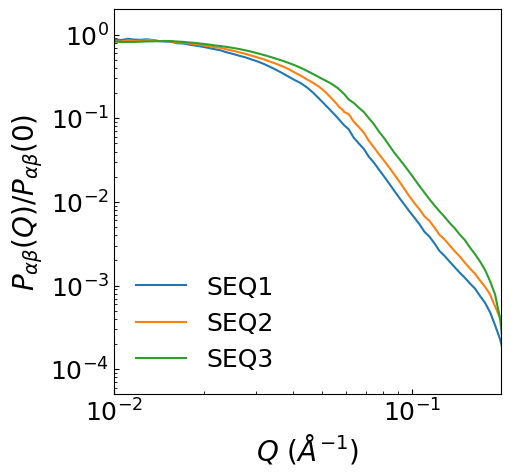

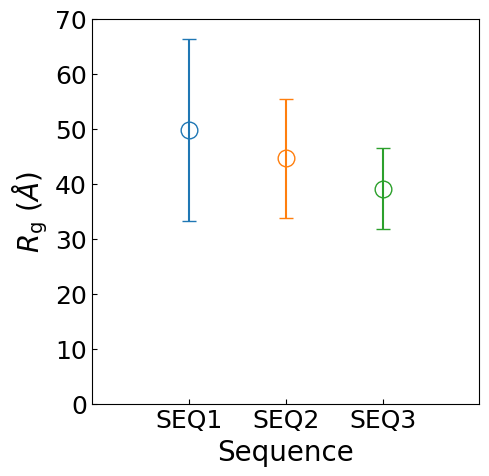

In [9]:
# summarize results
# read the results from results_dict_cvsans
with open('results_dict_cvsans.txt', 'r') as file:
    results_dict_cvsans = json.load(file)

fig1 = plt.figure(figsize=(5,5))
ax1 = fig1.add_subplot(111) 

fig2 = plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111) 
for i_seq, seq in enumerate(list_seq):
    print('seq = {}'.format(seq))
    
    Q_fit = np.array(results_dict_cvsans[seq]['Q_fit'])
    P_alpha_beta = np.array(results_dict_cvsans[seq]['P_alpha_beta'])
    list_I_0 = np.array(results_dict_cvsans[seq]['list_I_0'])
    list_R_g = np.array(results_dict_cvsans[seq]['list_R_g'])
    list_dR_g = np.array(results_dict_cvsans[seq]['list_dR_g'])
    
    ax1.plot(Q_fit, P_alpha_beta[0]/list_I_0[0], label=seq, color=colors[i_seq])
    
    ax2.errorbar(i_seq, list_R_g[0], yerr=list_dR_g[0], fmt='o', markersize=12, capsize=5, fillstyle='none', label=seq, color=colors[i_seq])
    
    
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim([5e-5, 2])
ax1.set_xlim([0.01, 0.2])

ax1.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax1.set_ylabel(r'$P_{\alpha\beta}(Q)/P_{\alpha\beta}(0)$', fontsize=20)
ax1.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax1.legend(fontsize=18, loc='best', frameon=False)

# ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_ylim([0, 70])
ax2.set_xlim([-1, len(list_seq)])

ax2.set_xticks(np.arange(len(list_seq)))
ax2.set_xticklabels(list_seq, fontsize=18)

ax2.set_xlabel(r'Sequence', fontsize=20)
ax2.set_ylabel(r'$R_\mathrm{g}\ (\AA)$', fontsize=20)
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18)
# ax2.legend(fontsize=18, loc='best', frameon=False)
    